In [293]:
import geopandas as gpd
import pyogrio as ogr
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import LineString, MultiLineString, Point, Polygon
import pandas as pd
import requests
import networkx as nx
import osmnx as ox
import h3
import libpysal as lps

In [294]:
# bounding box of nyc
bbox = (-74.3, 40.5, -73.7, 40.9)

In [295]:
# create a geodataframe of 100 random points
np.random.seed(0)
n = 100
df = pd.DataFrame(
    {
        "geometry": gpd.points_from_xy(
            np.random.uniform(-74.3, -73.7, n),
            np.random.uniform(40.5, 40.9, n),
        ),
    }
)

In [296]:
gdf = gpd.GeoDataFrame(df, crs="EPSG:4326")

<Axes: >

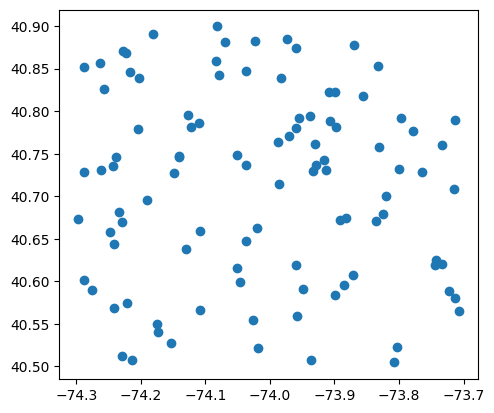

In [297]:
gdf.plot()

In [298]:
# find five nearest neighbors for each point, not including itself
k = 3
neighbors = gdf.geometry.apply(lambda x: gdf.geometry.distance(x)).values.argsort(
    axis=1
)[:, 1 : k + 1]

# join neighbors to original dataframe
gdf["neighbors"] = neighbors.tolist()

/var/folders/zg/m42dmv251nj6ml7dyhj2cgdr0000gn/T/ipykernel_44505/1591799713.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  neighbors = gdf.geometry.apply(lambda x: gdf.geometry.distance(x)).values.argsort(


In [299]:
gdf

,geometry,neighbors
0,POINT (-73.97071 40.77113),"[12, 28, 88]"
1,POINT (-73.87089 40.60800),"[83, 91, 42]"
2,POINT (-73.93834 40.79408),"[88, 12, 62]"
3,POINT (-73.97307 40.88488),"[84, 11, 22]"
4,POINT (-74.04581 40.59950),"[29, 41, 32]"
...,...,...
95,POINT (-74.19009 40.69618),"[61, 24, 57]"
96,POINT (-73.94809 40.59097),"[33, 50, 91]"
97,POINT (-74.28794 40.60174),"[75, 69, 67]"
98,POINT (-73.80264 40.52321),"[66, 8, 52]"


In [300]:
def create_lines(r):
    lines = []
    for i, neighbor in enumerate(r.neighbors):
        lines.append(LineString([r.geometry, gdf.loc[neighbor].geometry]))
    return MultiLineString(lines)

In [301]:
gdf["line_geometry"] = gdf.apply(create_lines, axis=1)

In [302]:
gdf

,geometry,neighbors,line_geometry
0,POINT (-73.97071 40.77113),"[12, 28, 88]","MULTILINESTRING ((-73.97071 40.77113, -73.9591..."
1,POINT (-73.87089 40.60800),"[83, 91, 42]","MULTILINESTRING ((-73.87089 40.60800, -73.8845..."
2,POINT (-73.93834 40.79408),"[88, 12, 62]","MULTILINESTRING ((-73.93834 40.79408, -73.9544..."
3,POINT (-73.97307 40.88488),"[84, 11, 22]","MULTILINESTRING ((-73.97307 40.88488, -73.9600..."
4,POINT (-74.04581 40.59950),"[29, 41, 32]","MULTILINESTRING ((-74.04581 40.59950, -74.0512..."
...,...,...,...
95,POINT (-74.19009 40.69618),"[61, 24, 57]","MULTILINESTRING ((-74.19009 40.69618, -74.2337..."
96,POINT (-73.94809 40.59097),"[33, 50, 91]","MULTILINESTRING ((-73.94809 40.59097, -73.9589..."
97,POINT (-74.28794 40.60174),"[75, 69, 67]","MULTILINESTRING ((-74.28794 40.60174, -74.2764..."
98,POINT (-73.80264 40.52321),"[66, 8, 52]","MULTILINESTRING ((-73.80264 40.52321, -73.8074..."


In [303]:
lines_gdf = gpd.GeoDataFrame(
    gdf[["line_geometry"]], geometry="line_geometry", crs="EPSG:4326"
)

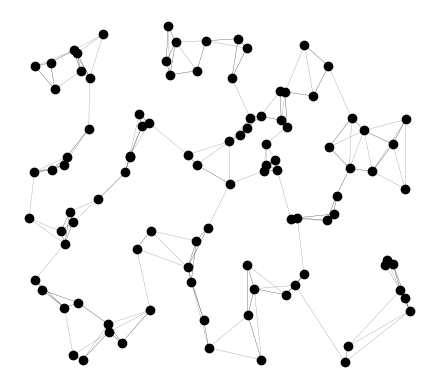

In [304]:
ax = lines_gdf.plot(color="black", alpha=0.5, linewidth=0.2)
gdf.plot(ax=ax, color="black").set_axis_off()
plt.savefig("lines.pdf", bbox_inches="tight", pad_inches=0)

In [305]:
gdf["line_geometry"].to_file("edges.geojson", driver="GeoJSON")

<Axes: >

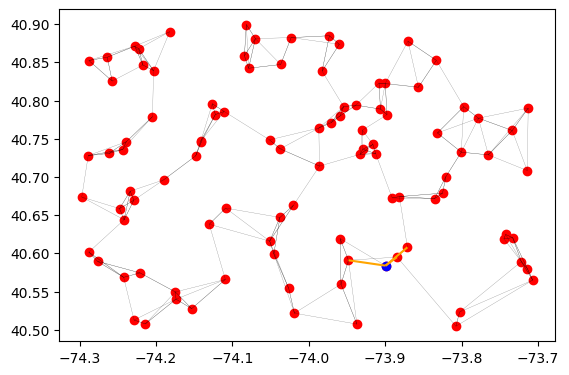

In [306]:
# plot the lines for a single point
s = gdf.sample(1)
ax = lines_gdf.plot(color="black", alpha=0.5, linewidth=0.2)
gdf.plot(ax=ax, color="red")

s.plot(ax=ax, color="blue")
gpd.GeoSeries(s.line_geometry).plot(ax=plt.gca(), color="orange")

# real-world example


## get restaurants in Morningside Heights


In [307]:
requests.get("https://data.cityofnewyork.us/resource/43nn-pn8j.json?NTA=MN09&$limit=2000")

<Response [200]>

How to request data without downloading the data table:

In [308]:
mh_restaurants = requests.get(
    "https://data.cityofnewyork.us/resource/43nn-pn8j.json?NTA=MN09&$limit=2000"
).json()

In [309]:
mh_restaurants = gpd.GeoDataFrame(
    mh_restaurants,
    geometry=gpd.points_from_xy(
        [float(x["longitude"]) for x in mh_restaurants],
        [float(x["latitude"]) for x in mh_restaurants],
    ),
)

In [310]:
mh_restaurants.fillna("na", inplace=True)

In [311]:
mh_restaurants.columns

Index(['camis', 'dba', 'boro', 'building', 'street', 'zipcode', 'phone',
       'inspection_date', 'critical_flag', 'record_date', 'latitude',
       'longitude', 'community_board', 'council_district', 'census_tract',
       'bin', 'bbl', 'nta', 'cuisine_description', 'action', 'violation_code',
       'violation_description', 'score', 'inspection_type', 'grade',
       'grade_date', 'geometry'],
      dtype='object')

In [312]:
mh_restaurants.drop_duplicates(subset="camis", inplace=True)

In [313]:
mh_restaurants.grade.value_counts()

grade
na    78
A     69
B     10
N      8
C      3
Z      1
P      1
Name: count, dtype: int64

In [314]:
mh_restaurants.cuisine_description.value_counts()

cuisine_description
American                          27
Coffee/Tea                        20
na                                16
Chinese                           10
Pizza                             10
Mexican                            8
Italian                            8
Japanese                           5
Juice, Smoothies, Fruit Salads     4
Sandwiches                         4
French                             4
Asian/Asian Fusion                 4
Hamburgers                         4
Ethiopian                          3
Indian                             3
Thai                               3
Other                              3
Frozen Desserts                    2
Greek                              2
Sandwiches/Salads/Mixed Buffet     2
Fusion                             2
Hawaiian                           2
Donuts                             2
Tex-Mex                            2
Latin American                     2
Mediterranean                      2
Bakery Products/De

## build graph to allow us to search


In [315]:
mh_bbox = mh_restaurants.total_bounds

In [316]:
mh_bbox

array([-73.96804436,  40.79882472, -73.9527956 ,  40.81532499])

In [317]:
mh_network = ox.graph_from_bbox(
    mh_bbox[3], mh_bbox[1], mh_bbox[2], mh_bbox[0], network_type="walk"
)

/var/folders/zg/m42dmv251nj6ml7dyhj2cgdr0000gn/T/ipykernel_44505/307712133.py:1: FutureWarning: The `north`, `south`, `east`, and `west` parameters are deprecated and will be removed in the v2.0.0 release. Use the `bbox` parameter instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  mh_network = ox.graph_from_bbox(


In [318]:
mh_net_nodes, mh_net_edges = ox.graph_to_gdfs(mh_network)

In [319]:
mh_net_edges

osmid               name  \
u           v           key                                                
42421737    10171363583 0                   195743201  West 106th Street   
            10171363584 0                   420625562    Columbus Avenue   
            10171363585 0                   420625563    Columbus Avenue   
            10171363586 0                   420625567  West 106th Street   
42421741    10166004078 0                   196116970   Amsterdam Avenue   
...                                               ...                ...   
12029862493 10169289722 0    [1111545257, 1290131566]                NaN   
12029862494 12029862492 0                  1298647984  West 116th Street   
            12029862493 0                  1298647984  West 116th Street   
            3579426871  0                  1298647985   Claremont Avenue   
12036804275 1778676696  0                  1299393701                NaN   

                                 highway  oneway reversed  length lanes  \
u           v           key                                               
42421737    10171363583 0      secondary   False     True  12.354   NaN   
            10171363584 0        primary   False     True  12.763     4   
            10171363585 0        primary   False    False  11.700     3   
            10171363586 0      secondary   False     True  12.512     2   
42421741    10166004078 0        primary   False    False  12.881     3   
...                                  ...     ...      ...     ...   ...   
12029862493 10169289722 0        footway   False    False   7.784   NaN   
12029862494 12029862492 0    residential   False    False  75.910   NaN   
            12029862493 0    residential   False     True  10.019   NaN   
            3579426871  0    residential   False     True   8.602   NaN   
12036804275 1778676696  0        footway   False     True   6.268   NaN   

                            maxspeed  \
u           v           key            
42421737    10171363583 0        NaN   
            10171363584 0     25 mph   
            10171363585 0     25 mph   
            10171363586 0        NaN   
42421741    10166004078 0        NaN   
...                              ...   
12029862493 10169289722 0        NaN   
12029862494 12029862492 0        NaN   
            12029862493 0        NaN   
            3579426871  0        NaN   
12036804275 1778676696  0        NaN   

                                                                      geometry  \
u           v           key                                                      
42421737    10171363583 0    LINESTRING (-73.96287 40.79924, -73.96275 40.7...   
            10171363584 0    LINESTRING (-73.96287 40.79924, -73.96280 40.7...   
            10171363585 0    LINESTRING (-73.96287 40.79924, -73.96294 40.7...   
            10171363586 0    LINESTRING (-73.96287 40.79924, -73.96300 40.7...   
42421741    10166004078 0    LINESTRING (-73.96569 40.80043, -73.96562 40.8...   
...                                                                        ...   
12029862493 10169289722 0    LINESTRING (-73.96502 40.80844, -73.96505 40.8...   
12029862494 12029862492 0    LINESTRING (-73.96491 40.80840, -73.96412 40.8...   
            12029862493 0    LINESTRING (-73.96491 40.80840, -73.96502 40.8...   
            3579426871  0    LINESTRING (-73.96491 40.80840, -73.96486 40.8...   
12036804275 1778676696  0    LINESTRING (-73.95802 40.80073, -73.95796 40.8...   

                            junction access tunnel bridge width service  
u           v           key                                              
42421737    10171363583 0        NaN    NaN    NaN    NaN   NaN     NaN  
            10171363584 0        NaN    NaN    NaN    NaN   NaN     NaN  
            10171363585 0        NaN    NaN    NaN    NaN   NaN     NaN  
            10171363586 0        NaN    NaN    NaN    NaN   NaN     NaN  
42421741    10166004078 0        NaN    NaN    NaN 

In [320]:
mh_net_nodes

,y,x,highway,street_count,geometry
osmid,,,,,
42421737,40.799244,-73.962873,traffic_signals,4,POINT (-73.96287 40.79924)
42421741,40.800429,-73.965691,traffic_signals,4,POINT (-73.96569 40.80043)
42421745,40.801398,-73.967996,traffic_signals,4,POINT (-73.96800 40.80140)
42421852,40.812622,-73.956823,traffic_signals,3,POINT (-73.95682 40.81262)
42421857,40.813822,-73.959800,traffic_signals,4,POINT (-73.95980 40.81382)
...,...,...,...,...,...
12029862491,40.808739,-73.965726,crossing,4,POINT (-73.96573 40.80874)
12029862492,40.808069,-73.964123,crossing,4,POINT (-73.96412 40.80807)
12029862493,40.808442,-73.965017,crossing,4,POINT (-73.96502 40.80844)


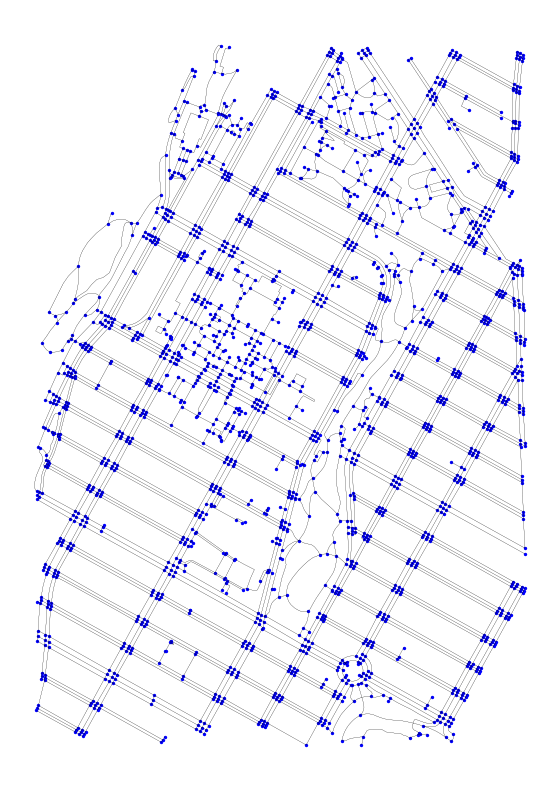

In [321]:
ax = mh_net_edges.plot(color="black", linewidth=0.1, figsize=(10, 10))
mh_net_nodes.plot(ax=ax, color="blue", markersize=2).set_axis_off()

In [322]:
buell_hall = Point(-73.9614755, 40.8077424)

### get directions between avery hall and a random restaurant using osmnx


In [323]:
# get the nearest node to buell hall
orig = ox.distance.nearest_nodes(mh_network, buell_hall.x, buell_hall.y)
sample = mh_restaurants.sample(1)
dest = ox.distance.nearest_nodes(mh_network, sample.geometry.x, sample.geometry.y)[0]

In [324]:
orig

3579426847

In [325]:
dest

11851500941

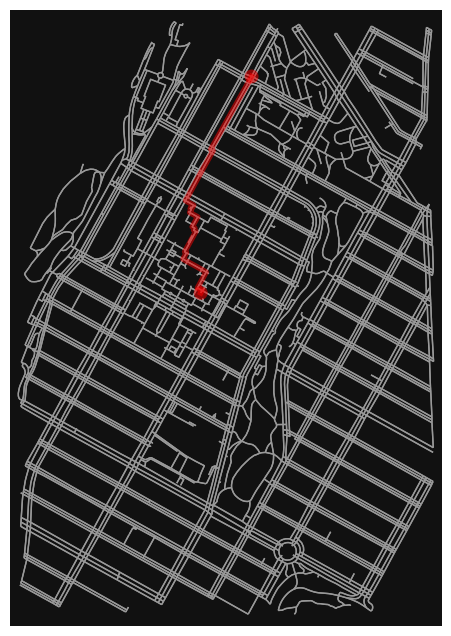

In [326]:
# find the shortest path between nodes, minimizing travel time, then plot it
route = ox.shortest_path(mh_network, orig, dest, weight="length")
fig, ax = ox.plot_graph_route(mh_network, route, node_size=0)

In [327]:
edge_lengths = ox.routing.route_to_gdf(mh_network, route)["length"]

# convert meters to miles
sum(edge_lengths) / 1609.34

0.5331831682553096

In [328]:
mh_pizza = mh_restaurants[mh_restaurants.cuisine_description == "Pizza"]

<Axes: >

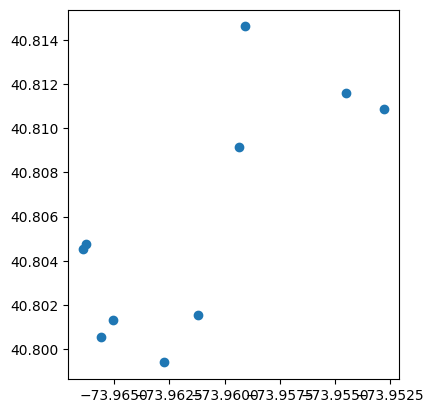

In [329]:
mh_pizza.plot()

In [330]:
def distance_from_point(row, origin):
    """
    Returns the distance in miles and the geometry of the shortest path between a point and a destination.

    Parameters:
    row (pd.Series): A row from a pandas DataFrame.
    origin (int): The origin node in the network.
    """

    dest = ox.distance.nearest_nodes(mh_network, row.geometry.x, row.geometry.y)  # [0]
    route = ox.shortest_path(mh_network, origin, dest, weight="length")
    edge_lengths = ox.routing.route_to_gdf(mh_network, route)["length"]

    route_geom = ox.routing.route_to_gdf(mh_network, route)
    route_geom = route_geom.geometry.unary_union

    return {"distance": sum(edge_lengths) / 1609.34, "route_geom": route_geom}

In [331]:
mh_pizza["distance_from_avery"] = mh_pizza.apply(
    distance_from_point, origin=orig, axis=1
)

/opt/anaconda3/envs/CDP/lib/python3.12/site-packages/geopandas/geodataframe.py:1528: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [332]:
mh_pizza["distance_from_avery"]

21     {'distance': 0.4293598618067034, 'route_geom':...
31     {'distance': 0.4293598618067034, 'route_geom':...
52     {'distance': 0.6579144245467086, 'route_geom':...
122    {'distance': 0.636129717772503, 'route_geom': ...
144    {'distance': 0.5626822175550226, 'route_geom':...
157    {'distance': 0.585664930965489, 'route_geom': ...
161    {'distance': 0.27091043533373926, 'route_geom'...
329    {'distance': 0.5982353014279146, 'route_geom':...
617    {'distance': 0.7448836168864255, 'route_geom':...
745    {'distance': 0.7467029962593362, 'route_geom':...
Name: distance_from_avery, dtype: object

In [333]:
# explode the dictionary into separate columns
mh_pizza = pd.concat(
    [
        mh_pizza.drop(["distance_from_avery"], axis=1),
        mh_pizza["distance_from_avery"].apply(pd.Series),
    ],
    axis=1,
)

In [334]:
mh_pizza_routes = gpd.GeoDataFrame(mh_pizza, geometry="route_geom", crs="EPSG:4326")

Text(0.5, 1.0, 'Distance from Buell Hall to \n Morningside Heights Pizza Restaurants')

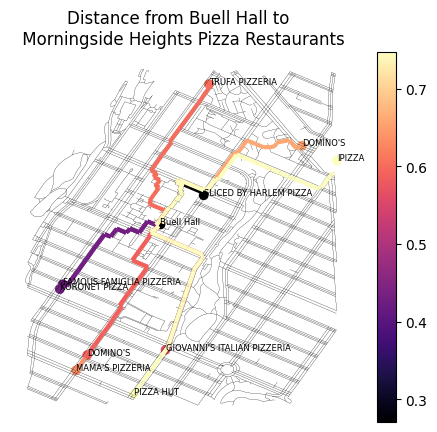

In [335]:
ax = gpd.GeoSeries(buell_hall).plot(color="black")
mh_net_edges.plot(ax=ax, color="black", linewidth=0.1)
mh_pizza_routes.plot(column="distance", cmap="magma", ax=ax, linewidth=3)
mh_pizza.plot(column="distance", cmap="magma", legend=True, ax=ax).set_axis_off()


# label each point
for x, y, label in zip(mh_pizza.geometry.x, mh_pizza.geometry.y, mh_pizza.dba):
    ax.text(x, y, label, fontsize=6)
ax.text(buell_hall.x, buell_hall.y, "Buell Hall", fontsize=6)

# title
plt.title("Distance from Buell Hall to \n Morningside Heights Pizza Restaurants")

In [336]:
mh_pizza[["dba", "distance"]].sort_values("distance")

,dba,distance
161,SLICED BY HARLEM PIZZA,0.270910
21,FAMOUS FAMIGLIA PIZZERIA,0.429360
31,KORONET PIZZA,0.429360
144,GIOVANNI'S ITALIAN PIZZERIA,0.562682
157,DOMINO'S,0.585665
329,TRUFA PIZZERIA,0.598235
122,MAMA'S PIZZERIA,0.636130
52,DOMINO'S,0.657914
617,IPIZZA,0.744884
745,PIZZA HUT,0.746703


<Axes: >

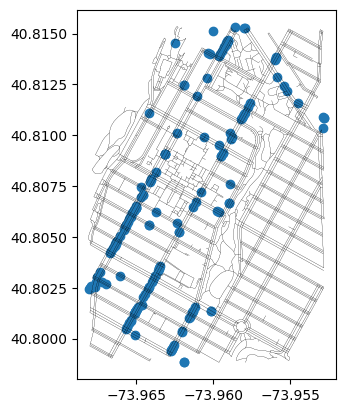

In [337]:
ax = mh_restaurants.plot()
mh_net_edges.plot(ax=ax, color="black", linewidth=0.1)

In [338]:
# use H3 grid to create a hexagon around the restaurants
# count the number of restaurants in each hexagon
# use pysal to get adjacency between hexagons
# build new network with hexagons as nodes and their adjacency as edges
# use networkx to find the shortest path between hexagons

# get the H3 hexagons

In [339]:
mh_net_nodes

,y,x,highway,street_count,geometry
osmid,,,,,
42421737,40.799244,-73.962873,traffic_signals,4,POINT (-73.96287 40.79924)
42421741,40.800429,-73.965691,traffic_signals,4,POINT (-73.96569 40.80043)
42421745,40.801398,-73.967996,traffic_signals,4,POINT (-73.96800 40.80140)
42421852,40.812622,-73.956823,traffic_signals,3,POINT (-73.95682 40.81262)
42421857,40.813822,-73.959800,traffic_signals,4,POINT (-73.95980 40.81382)
...,...,...,...,...,...
12029862491,40.808739,-73.965726,crossing,4,POINT (-73.96573 40.80874)
12029862492,40.808069,-73.964123,crossing,4,POINT (-73.96412 40.80807)
12029862493,40.808442,-73.965017,crossing,4,POINT (-73.96502 40.80844)


In [340]:
mh_net_nodes["h3"] = mh_net_nodes.apply(
    lambda x: h3.geo_to_h3(x.geometry.centroid.y, x.geometry.centroid.x, 9), axis=1
)

In [341]:
mh_net_nodes["h3"]

osmid
42421737       892a10088b3ffff
42421741       892a1008887ffff
42421745       892a100888fffff
42421852       892a1008c33ffff
42421857       892a1008c07ffff
                    ...       
12029862491    892a1008c67ffff
12029862492    892a1008c2bffff
12029862493    892a1008c67ffff
12029862494    892a1008c67ffff
12036804275    892a1008d4bffff
Name: h3, Length: 1989, dtype: object

In [342]:
# create hexagons for AOI
mh_net_nodes["geometry"] = mh_net_nodes["h3"].apply(
    lambda x: (h3.h3_to_geo_boundary(x))
)

/var/folders/zg/m42dmv251nj6ml7dyhj2cgdr0000gn/T/ipykernel_44505/2385662124.py:2: UserWarning: Geometry column does not contain geometry.
  mh_net_nodes["geometry"] = mh_net_nodes["h3"].apply(


In [343]:
# flip order of coordinates for each tuple
mh_net_nodes["geometry"] = mh_net_nodes["geometry"].apply(
    lambda x: Polygon([(y, x) for x, y in x])
)

In [344]:
mh_net_nodes.crs = "EPSG:4326"

In [345]:
mh_net_nodes.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [346]:
# mh_net_edges.to_crs("EPSG:2263", inplace=True)
# mh_net_nodes.to_crs("EPSG:2263", inplace=True)

In [347]:
mh_net_nodes

,y,x,highway,street_count,geometry,h3
osmid,,,,,,
42421737,40.799244,-73.962873,traffic_signals,4,"POLYGON ((-73.96198 40.79993, -73.96409 40.798...",892a10088b3ffff
42421741,40.800429,-73.965691,traffic_signals,4,"POLYGON ((-73.96422 40.80251, -73.96633 40.801...",892a1008887ffff
42421745,40.801398,-73.967996,traffic_signals,4,"POLYGON ((-73.96850 40.80240, -73.97061 40.801...",892a100888fffff
42421852,40.812622,-73.956823,traffic_signals,3,"POLYGON ((-73.95607 40.81332, -73.95818 40.812...",892a1008c33ffff
42421857,40.813822,-73.959800,traffic_signals,4,"POLYGON ((-73.95831 40.81590, -73.96042 40.814...",892a1008c07ffff
...,...,...,...,...,...,...
12029862491,40.808739,-73.965726,crossing,4,"POLYGON ((-73.96667 40.81039, -73.96878 40.809...",892a1008c67ffff
12029862492,40.808069,-73.964123,crossing,4,"POLYGON ((-73.96239 40.81050, -73.96450 40.809...",892a1008c2bffff
12029862493,40.808442,-73.965017,crossing,4,"POLYGON ((-73.96667 40.81039, -73.96878 40.809...",892a1008c67ffff


In [348]:
mh_net_nodes.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [361]:
mh_net_nodes_copy = mh_net_nodes.copy() 

In [362]:
mh_net_nodes_copy.drop_duplicates(subset=["h3"], inplace=True)

<Axes: >

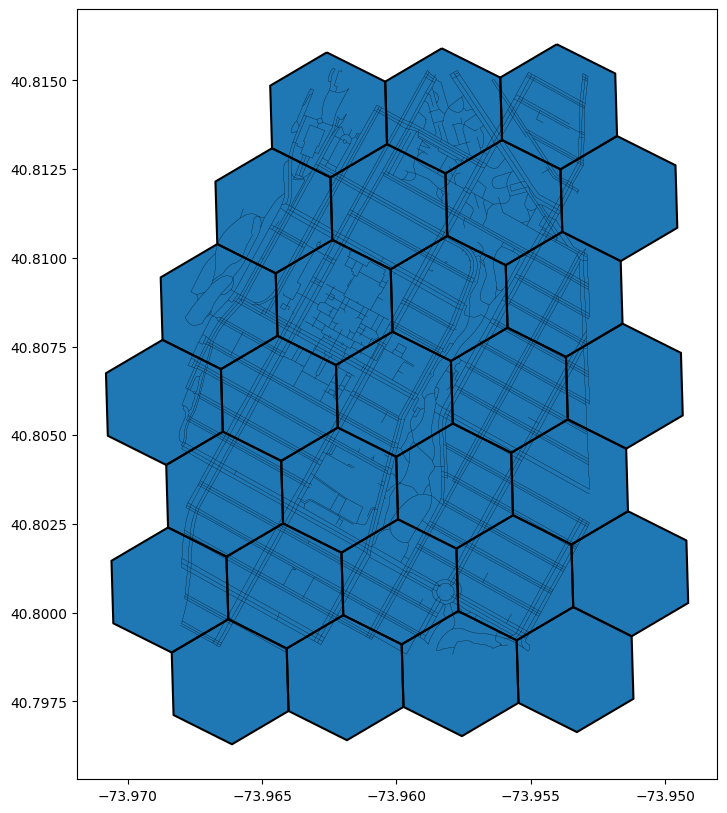

In [363]:
ax = mh_net_nodes.plot(figsize=(10, 10))
mh_net_nodes.boundary.plot(ax=ax, color="black")
mh_net_edges.plot(
    ax=ax,
    color="black",
    linewidth=0.1,
)  # .set_axis_off()

In [373]:
from lonboard import Map, PolygonLayer

In [365]:
layer = PolygonLayer.from_geopandas(
    mh_net_nodes[["geometry"]],
    get_line_color="black",
    get_fill_color="none",
    get_line_width=3,
)
# edges_layer = LineLayer.from_geopandas(
#     mh_net_edges[["geometry"]],
#     get_line_color="black",
#     get_fill_color="none",
#     get_line_width=1,
# )
m = Map(
    [
        layer,
    ]
)
m

Map(layers=[PolygonLayer(get_fill_color=(0, 0, 0, 0), get_line_color=(0, 0, 0, 255), get_line_width=3.0, table…

In [366]:
mh_net_nodes.drop_duplicates(subset="h3", inplace=True)

In [367]:
# create an adjacency matrix for the hexagons
w = lps.weights.Queen.from_dataframe(mh_net_nodes)

/var/folders/zg/m42dmv251nj6ml7dyhj2cgdr0000gn/T/ipykernel_44505/2435529990.py:2: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w = lps.weights.Queen.from_dataframe(mh_net_nodes)


In [374]:
w

In [375]:
# get neighbors for each hexagon
neighbors = {k: v for k, v in w.neighbors.items()}

In [376]:
neighbors

{0: [1, 18, 17, 23],
 1: [0, 2, 18, 6, 23, 12],
 2: [1, 6, 23],
 3: [16, 4, 21, 22, 8, 11],
 4: [8, 3, 5, 22],
 5: [8, 24, 4],
 6: [1, 2, 7, 12, 13],
 7: [19, 6, 25, 27, 12, 13],
 8: [3, 4, 5, 24, 27, 11],
 9: [16, 10, 20],
 10: [16, 19, 20, 9, 11, 15],
 11: [16, 3, 19, 8, 10, 27],
 12: [1, 18, 19, 6, 7, 15],
 13: [25, 6, 7],
 14: [17, 18, 20, 26, 28, 15],
 15: [18, 19, 20, 10, 12, 14],
 16: [3, 21, 9, 10, 11],
 17: [0, 18, 26, 14],
 18: [0, 1, 17, 12, 14, 15],
 19: [7, 27, 10, 11, 12, 15],
 20: [9, 10, 28, 14, 15],
 21: [16, 3, 22],
 22: [3, 4, 21],
 23: [0, 1, 2],
 24: [8, 25, 27, 5],
 25: [24, 27, 13, 7],
 26: [17, 28, 14],
 27: [19, 7, 8, 24, 11, 25],
 28: [26, 20, 14]}

In [378]:
# create networkx graph from adjacency matrix
G = nx.Graph(neighbors)

In [382]:
# get the path between two nodes
path = nx.shortest_path(G, 22, 23)

In [383]:
path

[22, 3, 11, 19, 12, 1, 23]

/var/folders/zg/m42dmv251nj6ml7dyhj2cgdr0000gn/T/ipykernel_44505/1576104426.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  mh_net_nodes.geometry.centroid.x,
/var/folders/zg/m42dmv251nj6ml7dyhj2cgdr0000gn/T/ipykernel_44505/1576104426.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  mh_net_nodes.geometry.centroid.y,


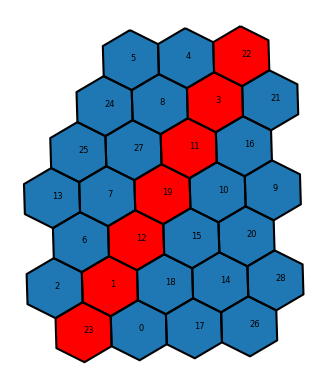

In [384]:
# plot the path
ax = mh_net_nodes.plot()
mh_net_nodes.boundary.plot(ax=ax, color="black")
mh_net_nodes.iloc[path].plot(ax=ax, color="red").set_axis_off()

# label cells with their index
for x, y, label in zip(
    mh_net_nodes.geometry.centroid.x,
    mh_net_nodes.geometry.centroid.y,
    neighbors.keys(),
):
    ax.text(x, y, label, fontsize=6)